# Drought magnitude/intensity

Assessment of model percentage multiannual drought (as a proxy for drought magnitude/intensity) bias 

In [17]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [18]:
def calc_drought(da, var):
    """
    calculate multiannual drought magnitude - the minimum of precipitation as a %-deviation of the climatological mean
    """
    annual_mean= da.groupby('time.year').sum(dim='time')
    annual_mean_min = annual_mean.min(dim='year')
    annual_mean_mean = annual_mean.mean(dim='year')
    drought_magn = ((annual_mean_min - annual_mean_mean) / abs(annual_mean_mean)) * 100

    moving_avg_2yr = da.groupby('time.year').sum(dim='time').rolling(year=2, min_periods=1, center=True).mean()#.dropna("year")
    min_moving_avg_2yr = moving_avg_2yr.min(dim='year')
    mean_moving_avg_2yr = moving_avg_2yr.mean(dim='year')
    drought_magn_2yr = ((min_moving_avg_2yr - mean_moving_avg_2yr) / abs(mean_moving_avg_2yr)) * 100
    
    moving_avg_5yr = da.groupby('time.year').sum(dim='time').rolling(year=5, min_periods=1, center=True).mean()#.dropna("year")
    min_moving_avg_5yr = moving_avg_5yr.min(dim='year')
    mean_moving_avg_5yr = moving_avg_5yr.mean(dim='year')
    drought_magn_5yr = ((min_moving_avg_5yr - mean_moving_avg_5yr) / abs(mean_moving_avg_5yr)) * 100  

    return drought_magn, drought_magn_2yr, drought_magn_5yr



In [19]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_dict['obs'] = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
   
    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [20]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, mode, ob_fractions=None):
    """Plot the mean bias for a particular model"""
    
    drought_magn_obs, drought_magn_2yr_obs, drought_magn_5yr_obs = calc_drought(da_obs, var)
    drought_magn_model, drought_magn_2yr_model, drought_magn_5yr_model = calc_drought(da_model, var)

    if mode == 'drought magnitude':
        bias = drought_magn_model - drought_magn_obs
    elif mode == 'drought magnitude \n 2-yr moving window':
        bias = drought_magn_2yr_model - drought_magn_2yr_obs
    elif mode == 'drought magnitude \n 5-yr moving window':
        bias = drought_magn_5yr_model - drought_magn_5yr_obs
    else:
        print('Invalid mode')
        return
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)  
    mae = np.nanmean(np.abs(bias))    
    
    units = '%' 
    
    im = bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14) 
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes)


In [24]:
def plot_comparison(var, gcm, rcm, task, cmap, levels):
    """Plot the complete comparison"""

    da_dict = get_data(var, gcm, rcm, task)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    modes= ['drought magnitude', 'drought magnitude \n 2-yr moving window', 'drought magnitude \n 5-yr moving window']

    ncols = 5 if task == 'xvalidation' else 4
    rows, cols = len(modes), ncols  
    
    fig, axs = plt.subplots(rows, cols, figsize=[7 * ncols, 6*rows], subplot_kw={'projection': ccrs.PlateCarree()})
    
    for row, mode in enumerate(modes):

        ax1 = axs[row, 0]
        ax2 = axs[row, 1]
        ax3 = axs[row, 2]
        ax4 = axs[row, 3]
        if task == 'xvalidation':
            ax5 = axs[row, 4]

        plot_mean_bias(ax1,da_dict['obs'], da_dict['gcm'], 'pr', cmap, levels, gcm, mode, ob_fractions=ob_fractions)
        ax1.set_title(f'{gcm} ({mode})', fontsize=16)

        plot_mean_bias(ax2, da_dict['obs'], da_dict['rcm_raw'], 'pr', cmap, levels, f'{rcm} (raw)', mode, ob_fractions=ob_fractions)
        ax2.set_title(f'{rcm} (raw) ({mode})', fontsize=16)

        plot_mean_bias(ax3, da_dict['obs'], da_dict['rcm_ecdfm'], 'pr', cmap, levels, f'{rcm} (ecdfm)', mode, ob_fractions=ob_fractions)
        ax3.set_title(f'{rcm} (ecdfm) ({mode})', fontsize=16)
        
        plot_mean_bias(ax4, da_dict['obs'], da_dict['rcm_qme'], 'pr', cmap, levels, f'{rcm} (qme)', mode, ob_fractions=ob_fractions)
        ax4.set_title(f'{rcm} (qme) ({mode})', fontsize=16)

        if task == 'xvalidation':
            plot_mean_bias(ax5, da_dict['obs'], da_dict['rcm_qdm'], 'pr', cmap, levels, f'{rcm} (qdm)', mode, ob_fractions=ob_fractions)
            ax5.set_title(f'{rcm} (qdm) ({mode})', fontsize=16)
        
    
    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f' Drought magnitude bias (model minus obs) for different modes in the {start_year}-2019 {long_name}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [25]:
variable = 'pr'
levels = np.arange(-37, 37.1, 5)
cmap = 'BrBG'

### ERA5

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'historical', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

### ACCESS-ESM1-5

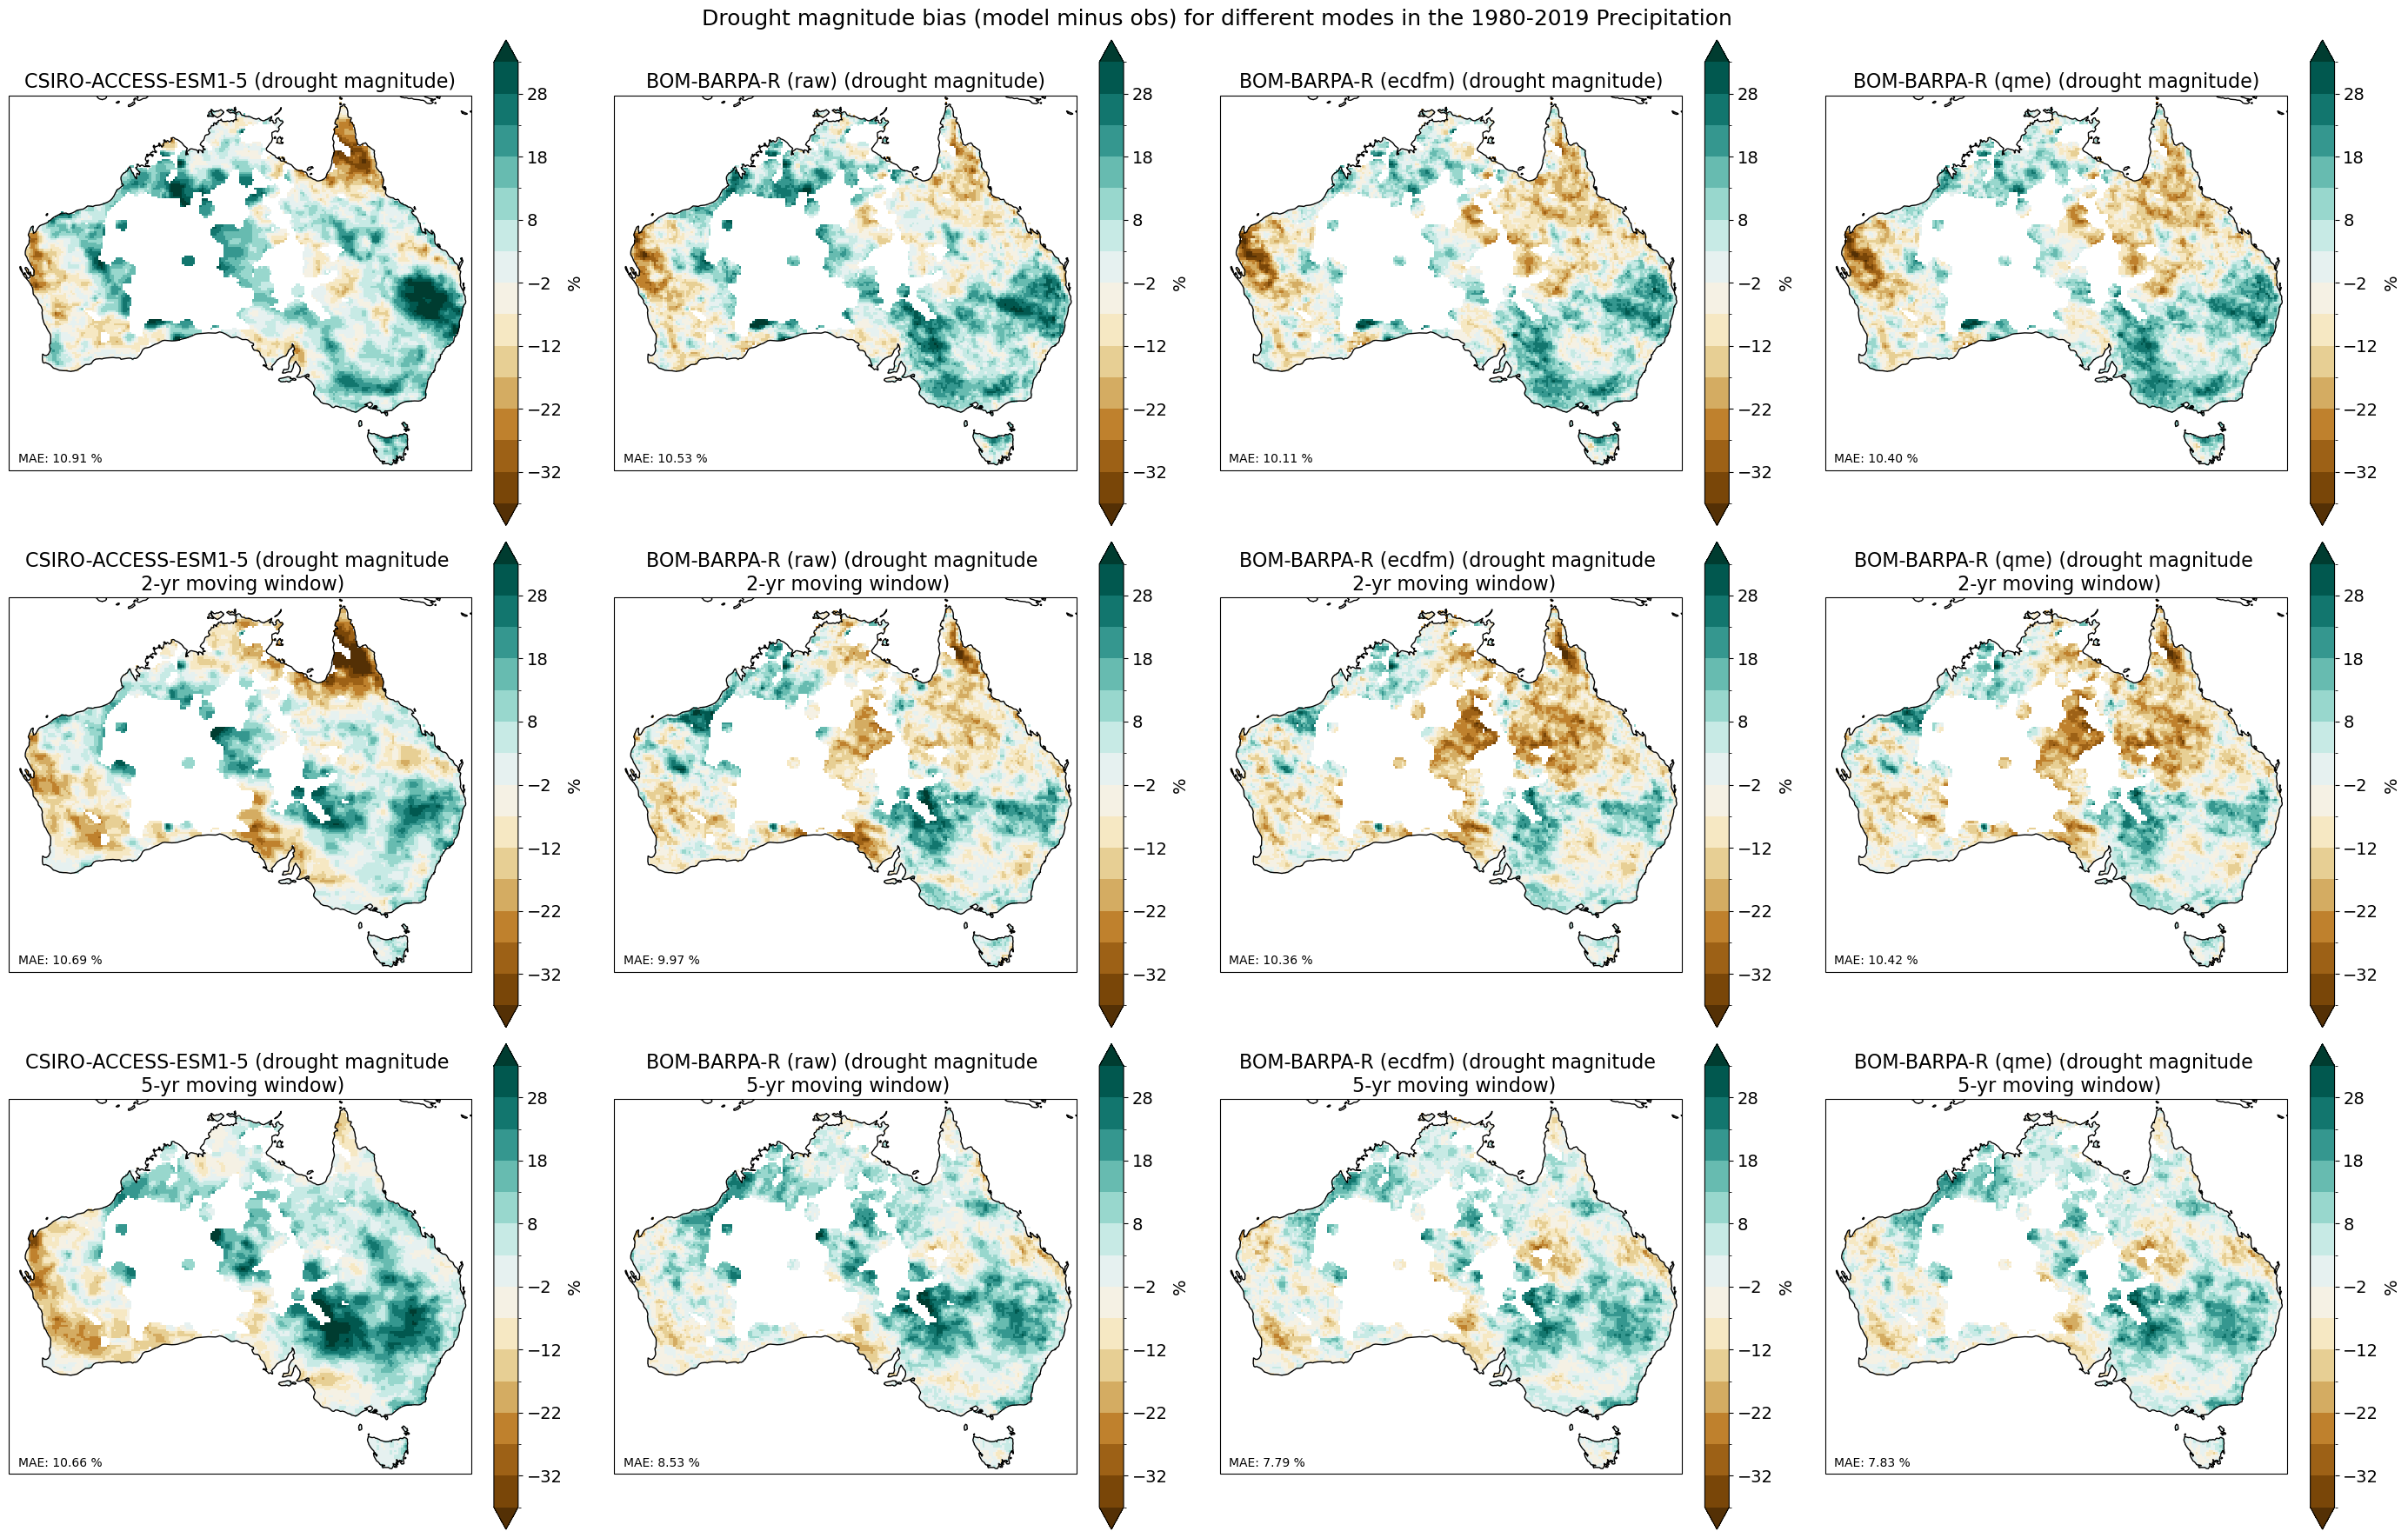

In [26]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical', cmap, levels)

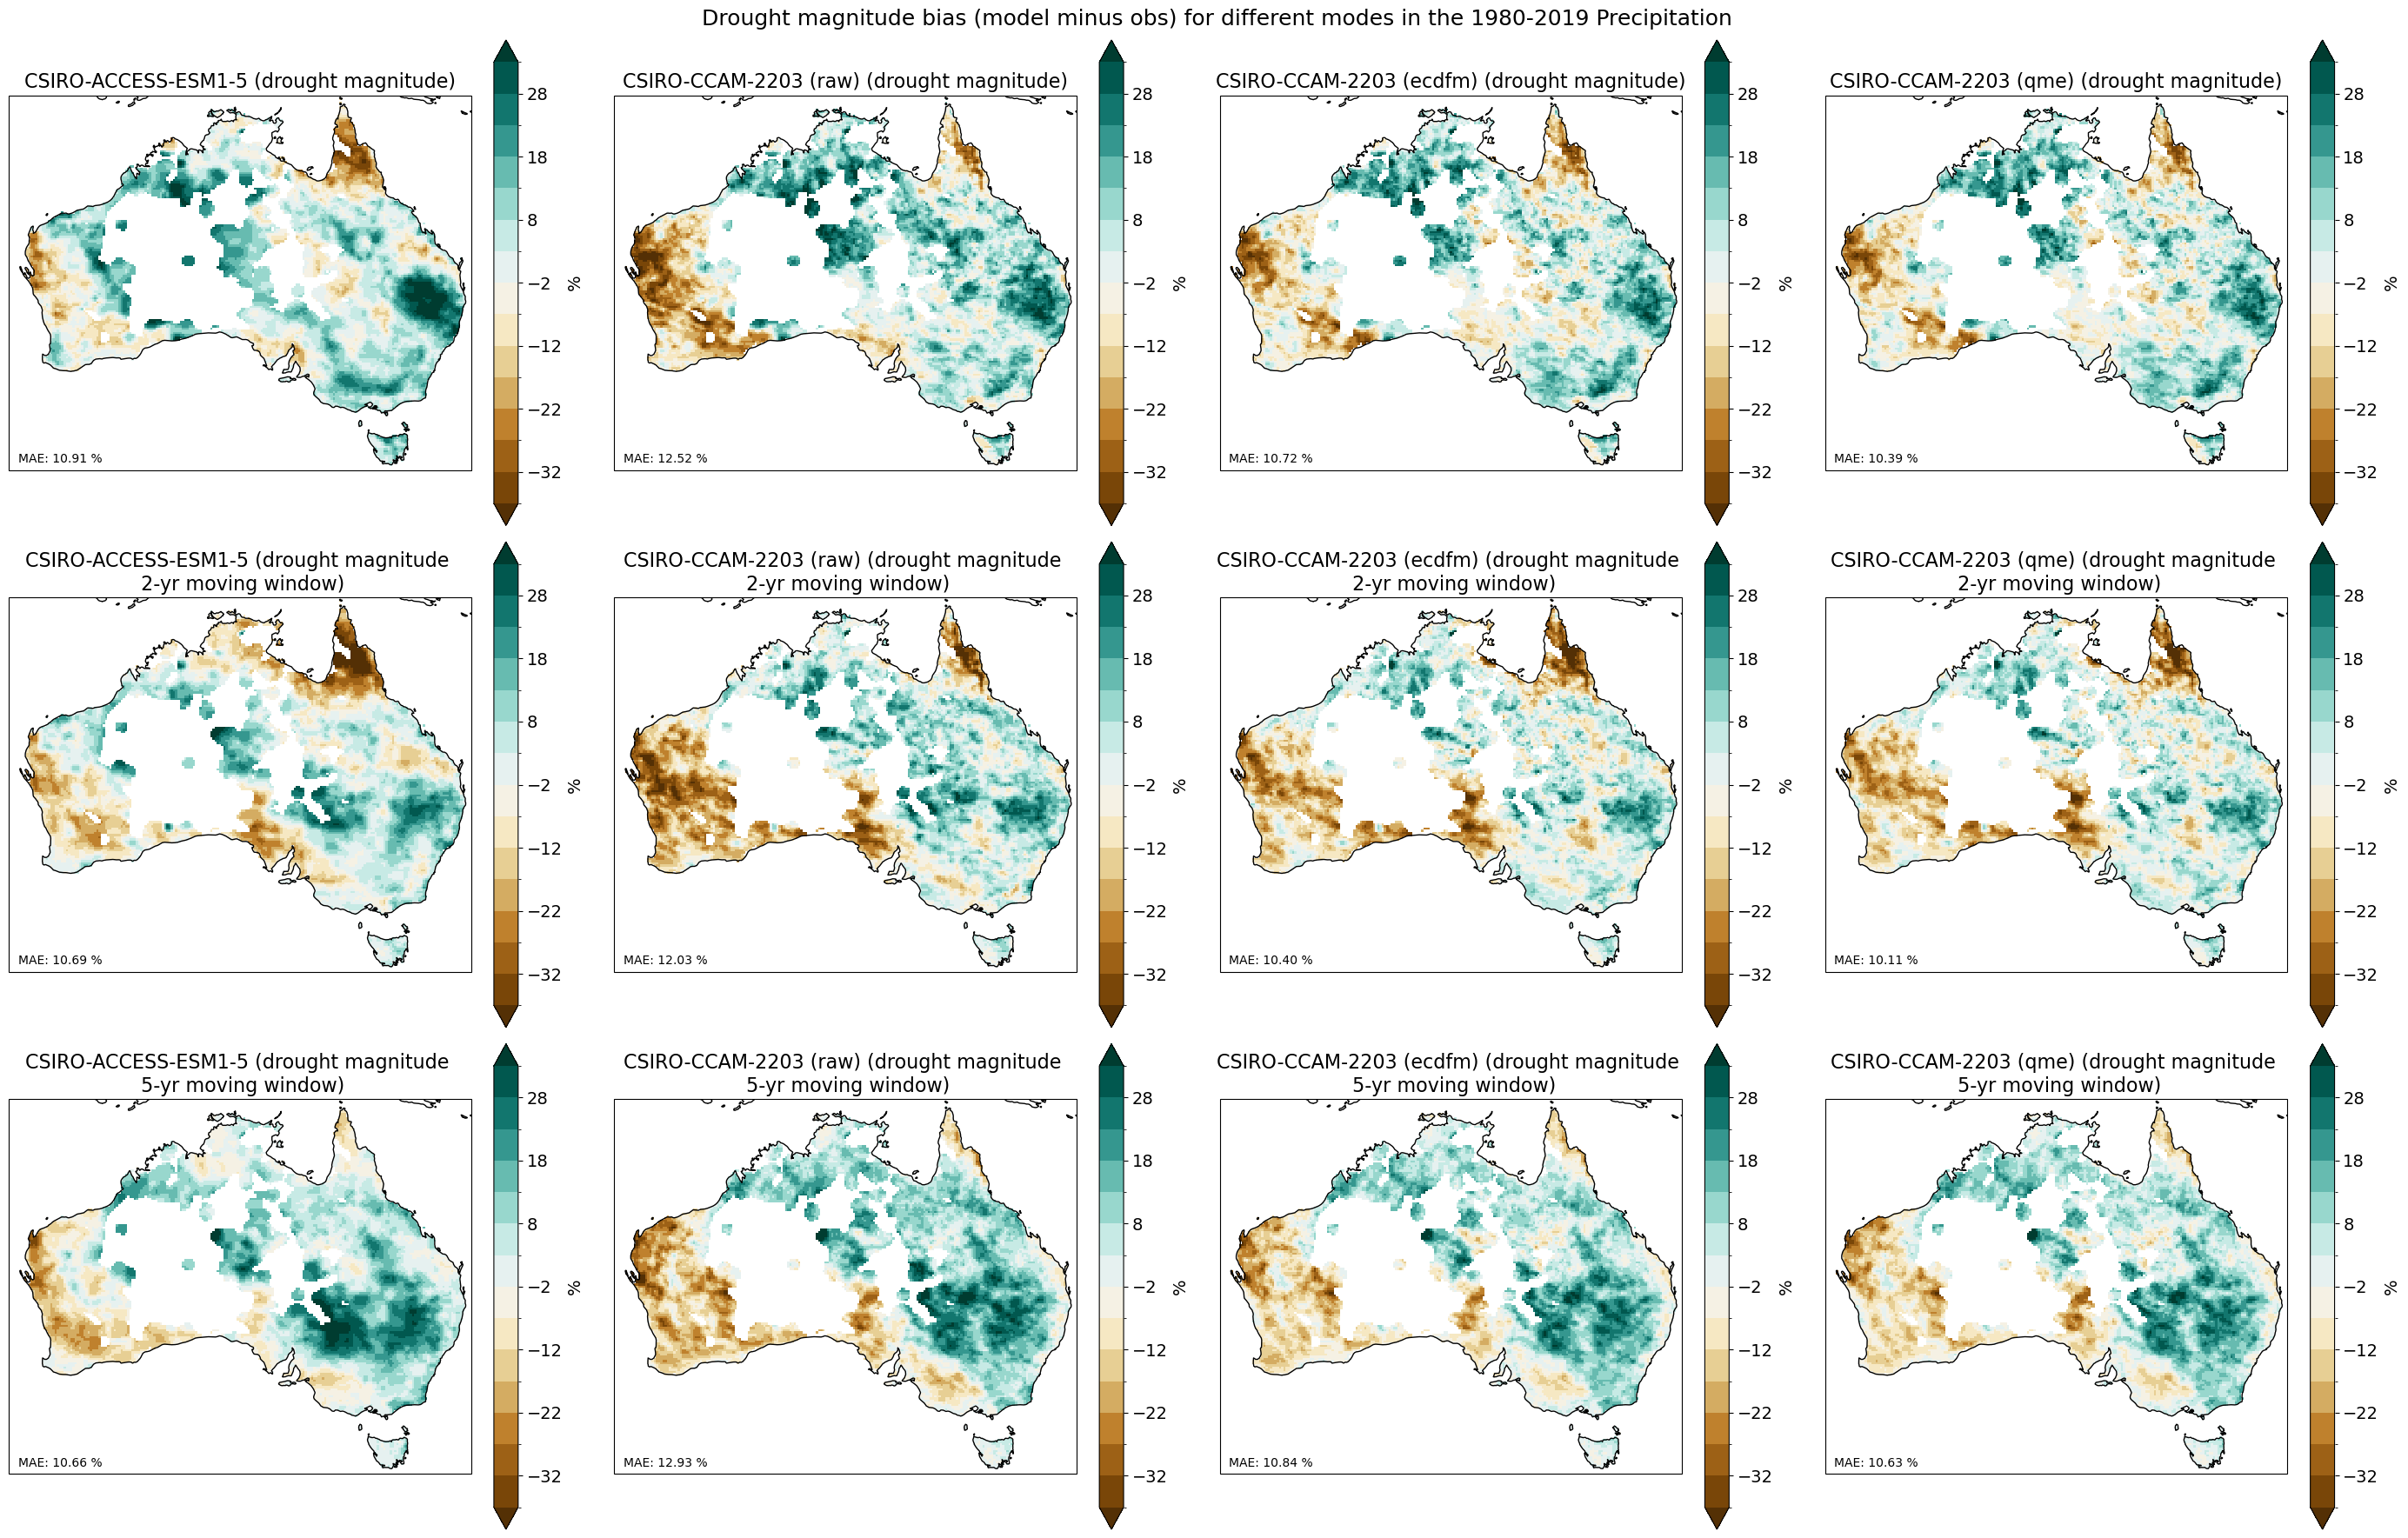

In [27]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

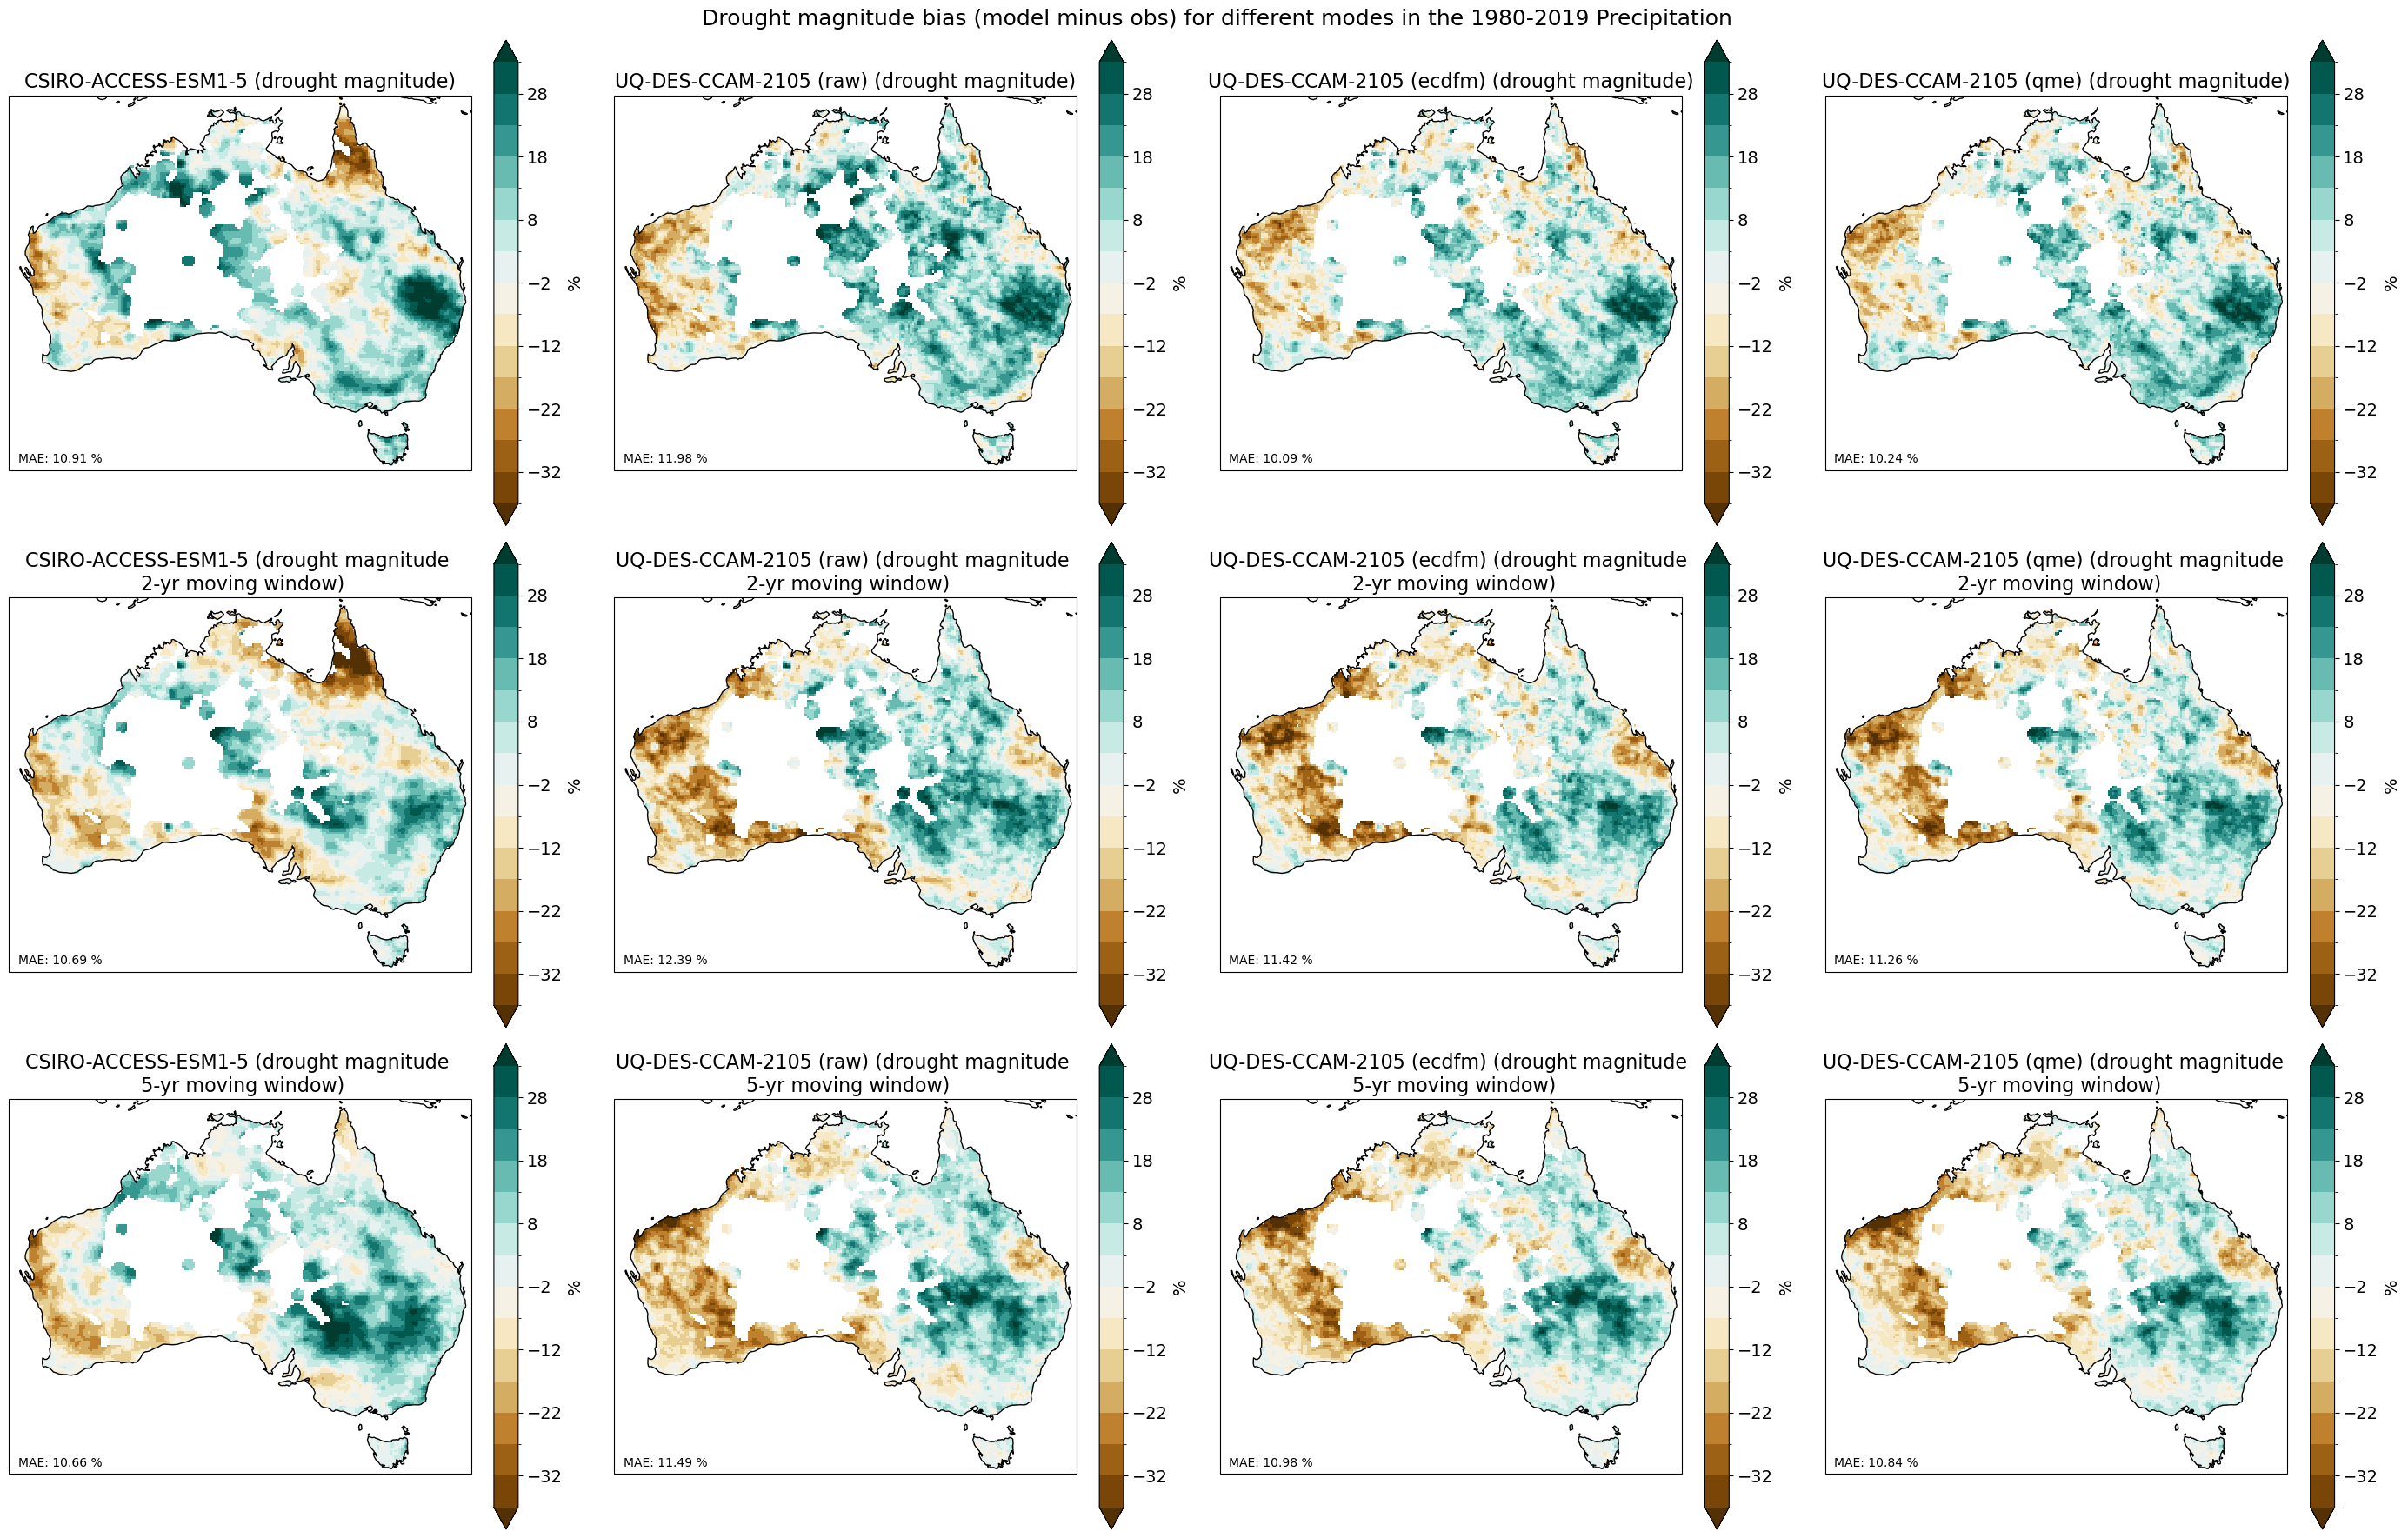

In [28]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

# task-xvalidation

### ERA5
Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)

### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

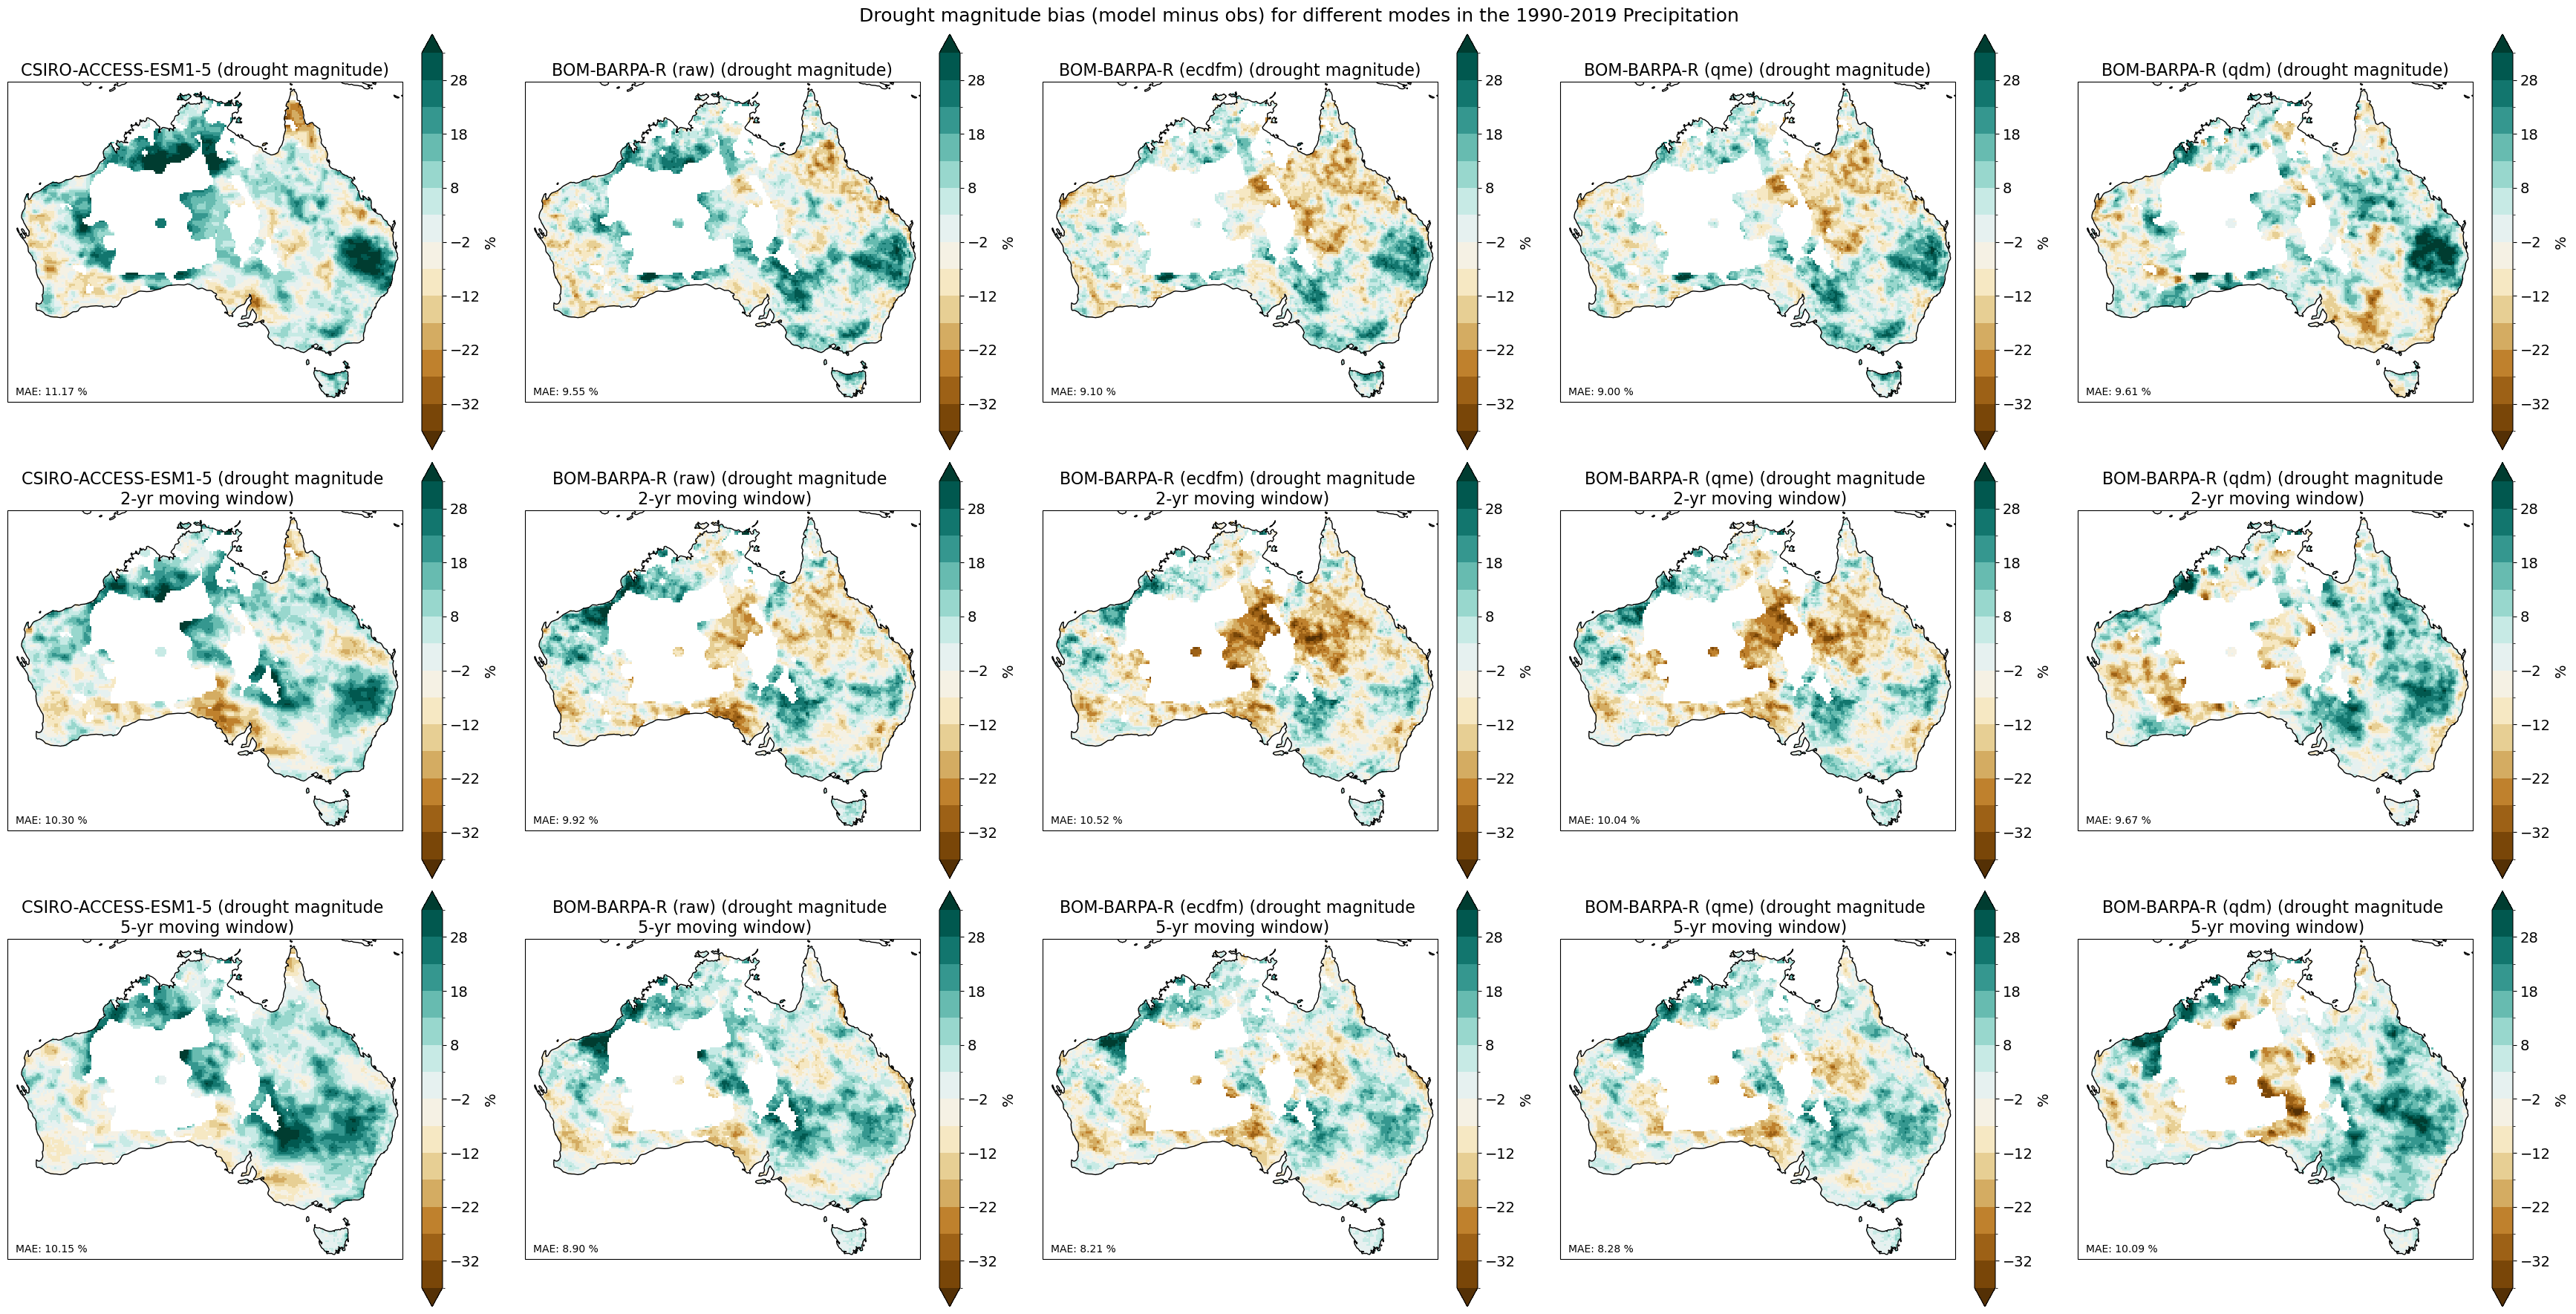

In [29]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

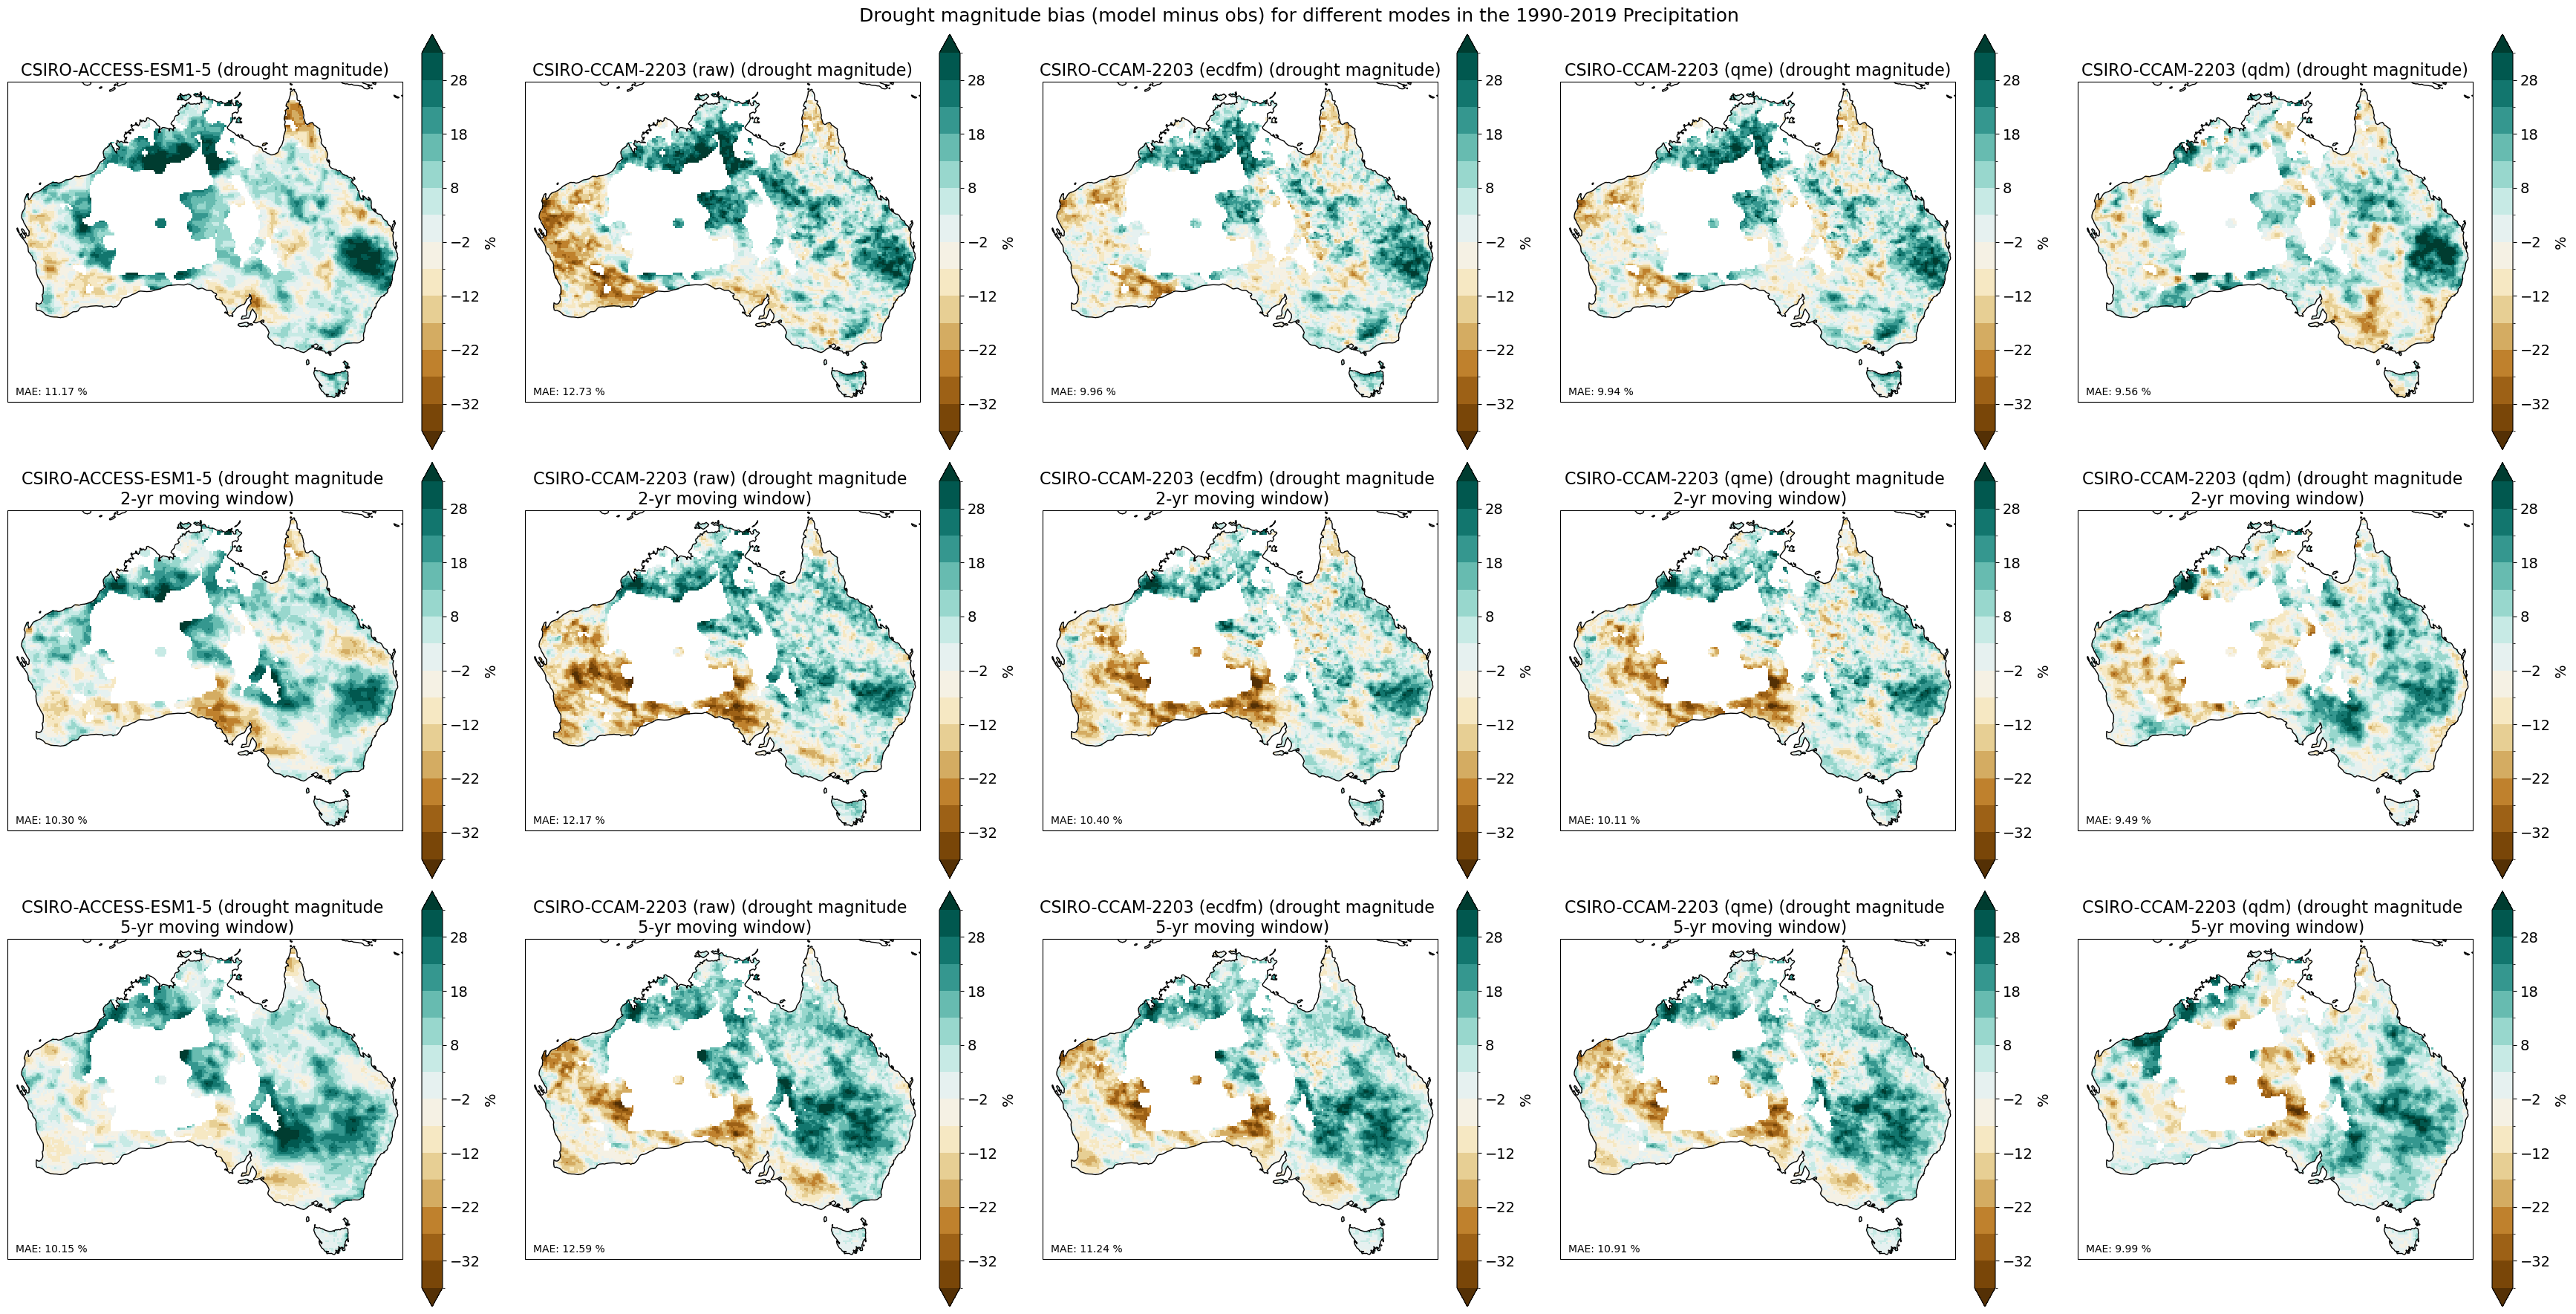

In [30]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

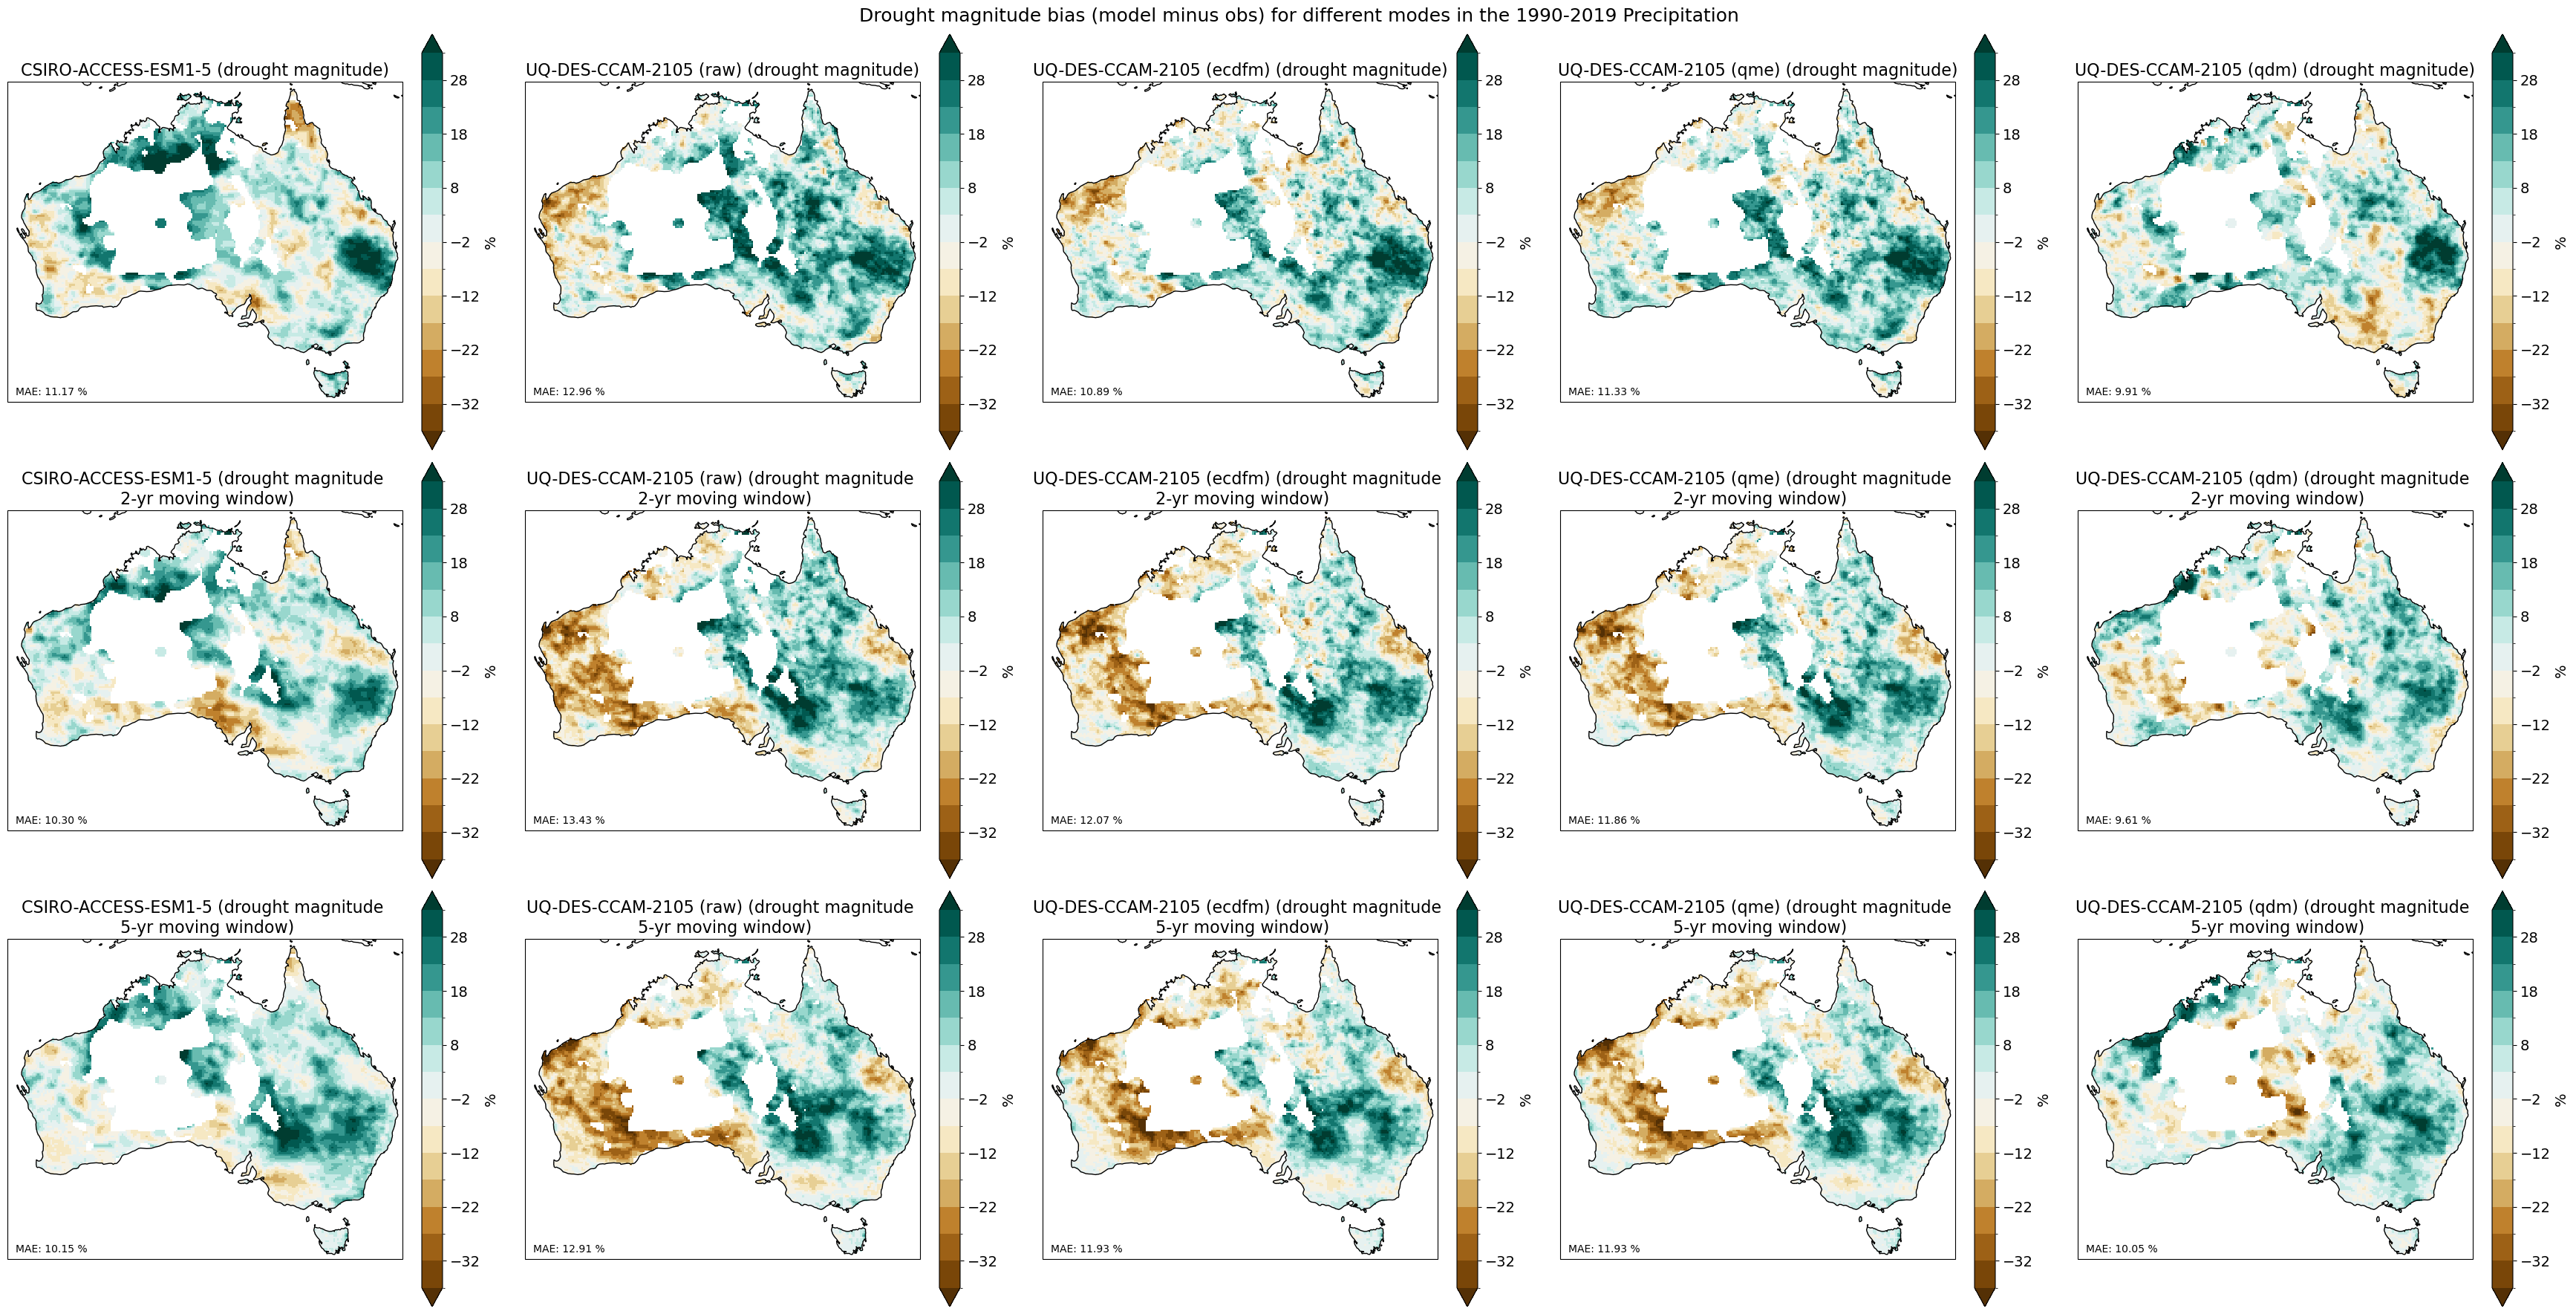

In [31]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)